In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, accuracy_score
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import skimage
import itertools

/home/ubuntu/DATN_Code_DatNT/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/DATN_Code_DatNT/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/DATN_Code_DatNT/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/DATN_Code_DatNT/lib/python3.6/site-packages/tensorf

In [2]:
image_size = 128
batch_size = 64
num_classes = 4
epochs = 15
data_path = 'preprocess_128x128/train/'
test_path = 'preprocess_128x128/test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255) # set validation split

train_generator = train_datagen.flow_from_directory(data_path, target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(data_path, target_size=(image_size,image_size),
                                                         batch_size=batch_size,
                                                         color_mode='grayscale',
                                                         class_mode='categorical',
                                                         subset='validation') # set as validation data


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path, target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  color_mode='grayscale',
                                                  class_mode='categorical')


Found 66762 images belonging to 4 classes.
Found 16689 images belonging to 4 classes.
Found 957 images belonging to 4 classes.


In [4]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)

In [5]:
#Tao model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add( Dense(4, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy',
#                         optimizer='adam',
#                         metrics=['accuracy'])  
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               32514304  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Tota

In [ ]:
filepath="weights_balanced_cnn_5layered_best7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the network
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples // batch_size,
                              epochs = epochs, 
                              callbacks=callbacks_list,
#                               class_weight=class_weights
                             )
model_json = model.to_json()
with open("paper8.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/15
  40/1043 [>.............................] - ETA: 7:38 - loss: 1.9198 - acc: 0.4625




Test Loss: 0.2740547895431519
Test accuracy: 0.9364583333333333


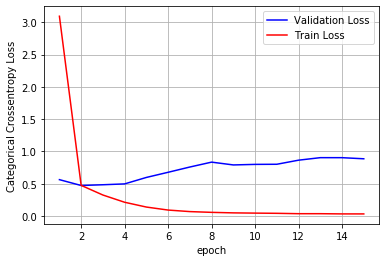

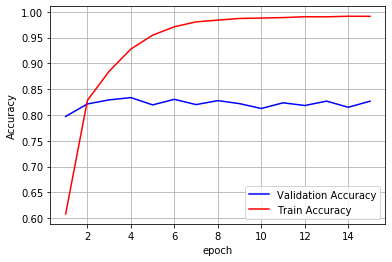

In [8]:
score = model.evaluate_generator(test_generator,steps = test_generator.samples // batch_size) 
print("\n\n")
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
history = history.history
x = list(range(1,epochs+1))
_,ax1 = plt.subplots(1,1)
ax1.plot(x, history['val_loss'], 'b', label="Validation Loss")
ax1.plot(x, history['loss'], 'r', label="Train Loss")
ax1.set_xlabel('epoch') 
ax1.set_ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid()
_,ax2 = plt.subplots(1,1)
ax2.plot(x, history['val_acc'], 'b', label="Validation Accuracy")
ax2.plot(x, history['acc'], 'r', label="Train Accuracy")
ax2.set_xlabel('epoch') 
ax2.set_ylabel('Accuracy')
plt.legend()
plt.grid()

In [ ]:
# X_test,Y_test= load_test_data(test_path)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
from tensorflow.keras.models import load_model
model = load_model('./weights_balanced_cnn_5layered_best7.hdf5')

In [8]:
pred_datagen = ImageDataGenerator(rescale=1./255)

pred_generator = pred_datagen.flow_from_directory(test_path,target_size=(image_size, image_size),
                                                  batch_size=1,
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  shuffle = False)   
pred_generator.reset()
y_pred = model.predict_generator(pred_generator,steps = pred_generator.samples)
Y_test = pred_generator.classes[pred_generator.index_array]
Y_pred = np.argmax(y_pred, axis=-1)
Y_pred = np.argmax(y_pred,axis = 1)



Found 999 images belonging to 4 classes.


accuracy:  0.938938938938939
--------------------
| Confusion Matrix |
--------------------

 [[246   3   1   0]
 [ 15 220   3  12]
 [ 18   2 228   1]
 [  0   3   3 244]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       250
           1       0.96      0.88      0.92       250
           2       0.97      0.92      0.94       249
           3       0.95      0.98      0.96       250

    accuracy                           0.94       999
   macro avg       0.94      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999



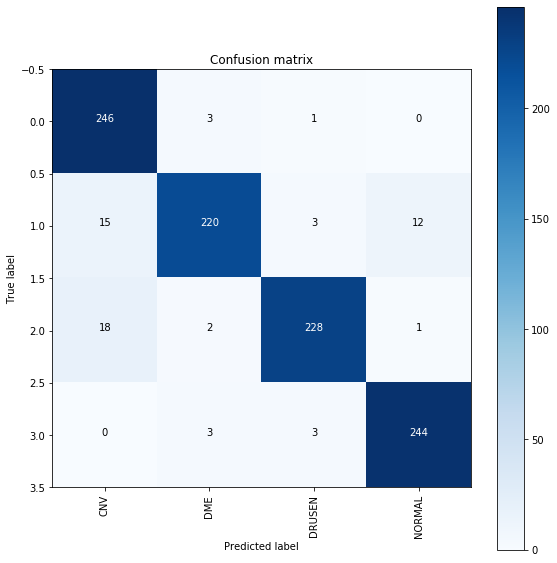

In [9]:
print('accuracy: ', accuracy_score(Y_test, Y_pred))
# confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
print(classification_report(Y_test, Y_pred))
# plot confusin matrix
plt.figure(figsize=(8, 8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()


In [ ]:
import os
os._exit(00)